# El evaluador de precios de productos (continuación)

Un modelo que puede estimar cuánto cuesta algo a partir de su descripción.

## ¡Nos marchamos a la Frontera!

Y ahora, ponemos a prueba los modelos de Frontier.

### Dos puntos importantes:

Es importante tener en cuenta que no estamos entrenando los modelos de Frontier. Solo les proporcionamos el conjunto de datos de prueba para ver cómo funcionan. No obtienen el beneficio de los 400 000 ejemplos de entrenamiento que proporcionamos a los modelos de ML tradicionales.

DICHO ESTO...

Es totalmente posible que en sus monstruosos datos de entrenamiento, ya hayan estado expuestos a todos los productos en el conjunto de entrenamiento Y de prueba. Por lo tanto, podría haber una "contaminación" de prueba aquí que les dé una ventaja injusta. Debemos tener eso en cuenta.

In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [2]:
# movimos nuestro Tester a un paquete separado
# lo llamamos mediante Tester.test(function_name, test_dataset)

from testing import Tester

In [3]:
# entorno

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in en HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
openai = OpenAI()
claude = Anthropic()

In [6]:
%matplotlib inline

In [7]:
# ¡Evitemos tener que volver a curar todos nuestros datos! Carguemos los archivos pickle:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# Antes de analizar los modelos Frontera

## Hay un modelo más que podríamos considerar

In [9]:
# Escribe el conjunto de pruebas en un CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [10]:
# Lo leemos de vuelta

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [11]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $374.41 Error: $254.41 SLE: 1.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $80.00 Truth: $225.11 Error: $145.11 SLE: 1.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $35.00 Truth: $61.68 Error: $26.68 SLE: 0.31 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $350.00 Truth: $599.99 Error: $249.99 SLE: 0.29 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $75.00 Truth: $16.99 Error: $58.01 SLE: 2.08 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.00 Truth: $31.99 Error: $19.99 SLE: 0.87 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $115.00 Truth: $101.79 Error: $13.21 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $100.00 Truth: $289.00 Error: $189.00 SLE: 1.11 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $300.00 Truth: $635.86 Error: $335.86 SLE: 0.56 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $80.00 Truth: $65.99 Error: $14.01 SLE: 0.0

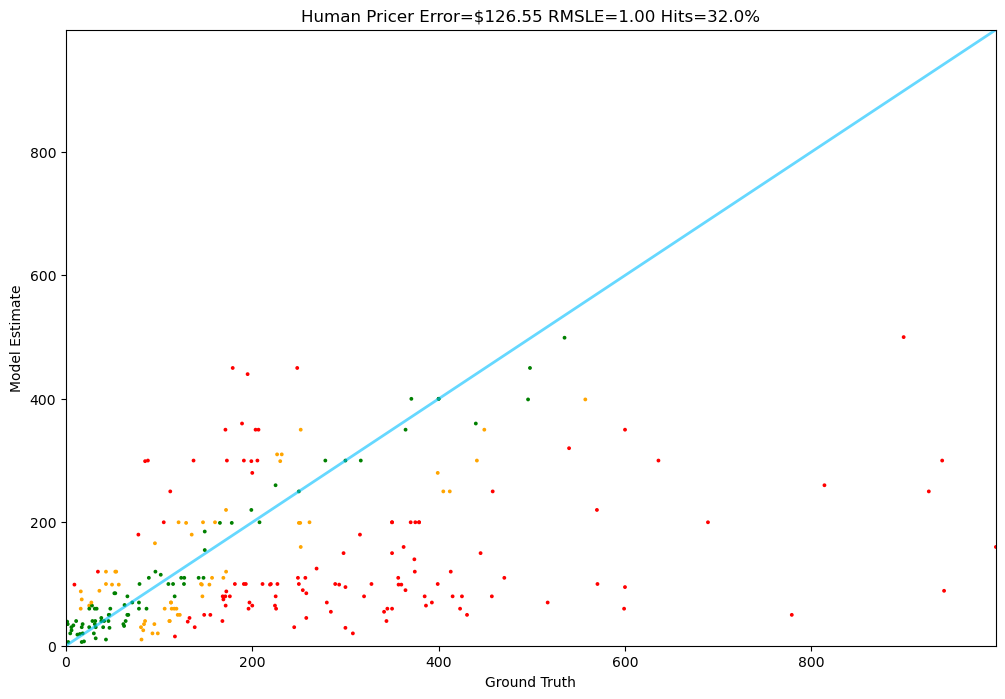

In [12]:
Tester.test(human_pricer, test)

## Primero, el humilde pero poderoso GPT-4o-mini

Se llama mini, pero es muy potente.

In [17]:
# Primero, trabajemos en un buen mensaje para un modelo Frontier
# Observe que estoy eliminando el "al dólar más cercano"
# Cuando entrenemos nuestros propios modelos, necesitaremos hacer que el problema sea lo más fácil posible,
# pero un modelo Frontier no necesita tal simplificación.

def messages_for(item):
    system_message = "Estimas los precios de los artículos. Respondes solo con el precio, sin explicaciones."
    user_prompt = item.test_prompt().replace(" redondeado al dólar más cercano","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "El precio es de $"}
    ]

In [18]:
# Vamos a probarlo

messages_for(test[0])

[{'role': 'system',
  'content': 'Estimas los precios de los artículos. Respondes solo con el precio, sin explicaciones.'},
 {'role': 'user',
  'content': "¿Cuánto cuesta esto?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'El preci

In [19]:
# Una función de utilidad para extraer el precio de un string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [23]:
get_price("El precio es de aproximadamente $99.99 porque bla, bla, bla.")

99.99

In [24]:
# La función para gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [25]:
test[0].price

374.41

1: Guess: $250.00 Truth: $374.41 Error: $124.41 SLE: 0.16 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $75.00 Truth: $225.11 Error: $150.11 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $35.99 Truth: $61.68 Error: $25.69 SLE: 0.28 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $400.00 Truth: $599.99 Error: $199.99 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $22.99 Truth: $16.99 Error: $6.00 SLE: 0.08 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $40.00 Truth: $101.79 Error: $61.79 SLE: 0.84 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $249.99 Truth: $289.00 Error: $39.01 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $599.00 Truth: $635.86 Error: $36.86 SLE: 0.00 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $50.00 Truth: $65.99 Error: $15.99 SLE: 0.07 It

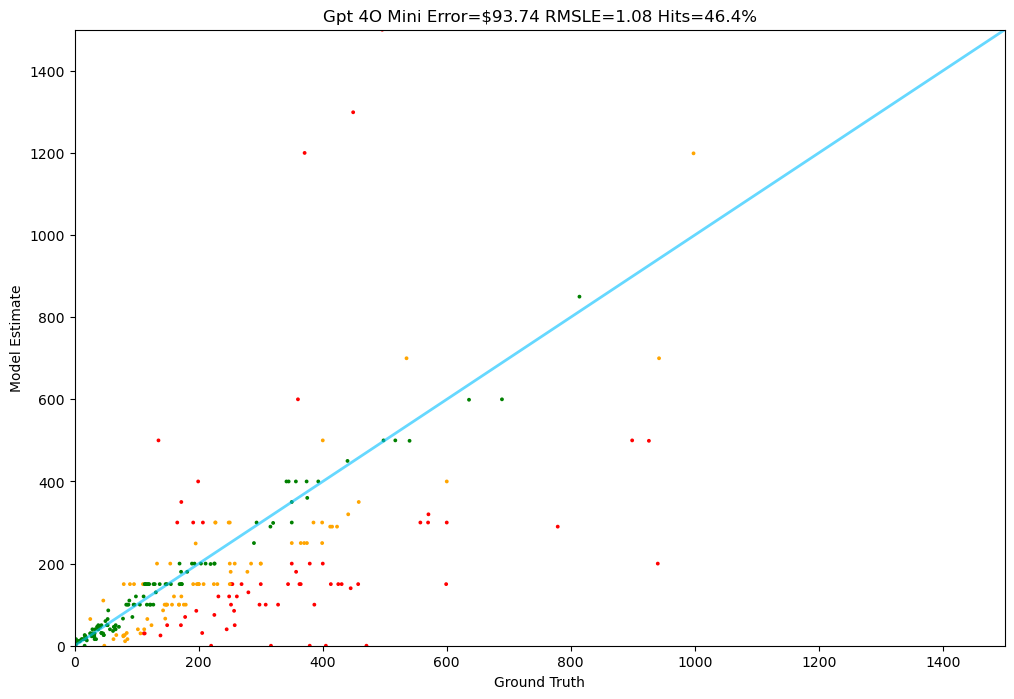

In [26]:
Tester.test(gpt_4o_mini, test)

In [27]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $0.00 Truth: $374.41 Error: $374.41 SLE: 35.14 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $150.00 Truth: $225.11 Error: $75.11 SLE: 0.16 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $40.00 Truth: $61.68 Error: $21.68 SLE: 0.18 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $400.00 Truth: $599.99 Error: $199.99 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $22.00 Truth: $16.99 Error: $5.01 SLE: 0.06 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $0.00 Truth: $101.79 Error: $101.79 SLE: 21.46 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $499.00 Truth: $289.00 Error: $210.00 SLE: 0.30 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $400.00 Truth: $635.86 Error: $235.86 SLE: 0.21 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $39.99 Truth: $65.99 Error: $26.00 SLE: 0.24 

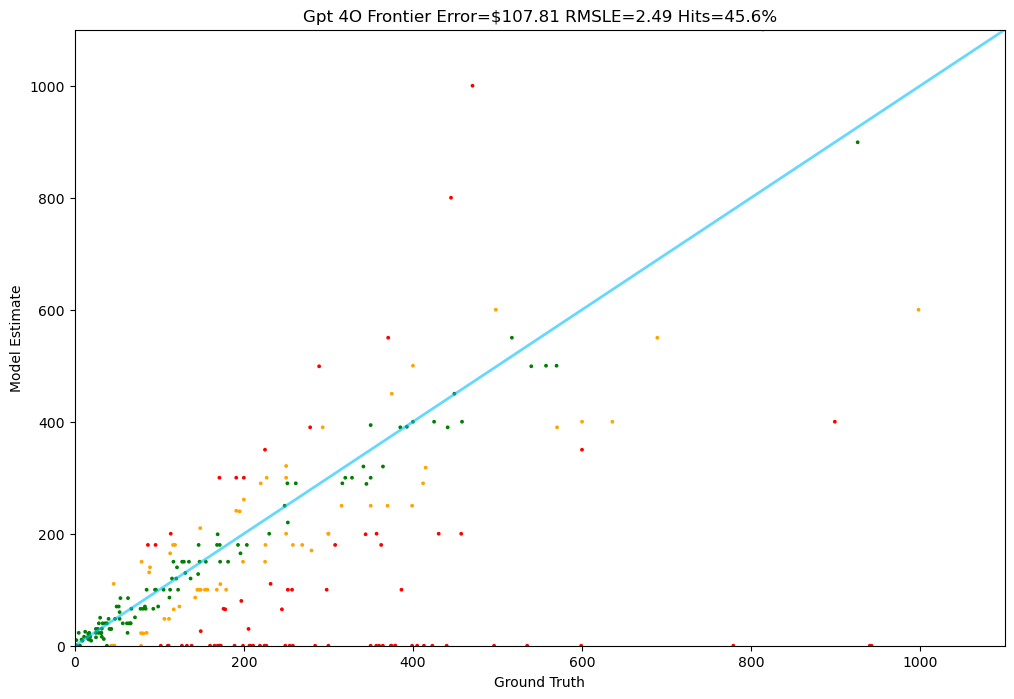

In [28]:
# La función para gpt-4o: el modelo de August
# Tenga en cuenta que me costó entre 1 y 2 céntimos ejecutar esto (el precio puede variar según la región)
# Puedes omitir esto y mirar mis resultados en su lugar

Tester.test(gpt_4o_frontier, test)

In [29]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

In [32]:
# La función para Claude 3.5 Sonnet
# También me costó entre 1 y 2 céntimos ejecutar esto (el precio puede variar según la región)
# Puedes omitir esto y ver mis resultados en su lugar

Tester.test(claude_3_point_5_sonnet, test)

1: Guess: $299.99 Truth: $374.41 Error: $74.42 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $95.00 Truth: $225.11 Error: $130.11 SLE: 0.73 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $25.00 Truth: $61.68 Error: $36.68 SLE: 0.77 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $499.99 Truth: $599.99 Error: $100.00 SLE: 0.03 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $15.99 Truth: $16.99 Error: $1.00 SLE: 0.00 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $59.99 Truth: $101.79 Error: $41.80 SLE: 0.27 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $279.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $399.00 Truth: $635.86 Error: $236.86 SLE: 0.22 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $59.99 Truth: $65.99 Error: $6.00 SLE: 0.01 Ite

InternalServerError: Error code: 500 - {'type': 'error', 'error': {'type': 'api_error', 'message': 'Internal server error'}}